In [2]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

import numpy as np
import time

In [3]:
train = pd.read_csv('./df_train.csv')
test = pd.read_csv('./df_test.csv')

In [4]:
X = train.drop(['Unnamed: 0','id','f_27','target'],axis=1)
y = train['target']
test.drop(['Unnamed: 0','id','f_27'],axis=1, inplace=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
X_train.columns

Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07', 'f_08',
       'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17',
       'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26',
       'f_28', 'f_29', 'f_30', 'f_27_set_len', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', 'sum_05_22', 'sum_02_21', 'sum_00_01_26'],
      dtype='object')

### HPT

In [6]:
# run with full fe, without hpt
model_xgb = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist')
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy is:  94.84
[[88214  4241]
 [ 5050 82495]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     92455
           1       0.95      0.94      0.95     87545

    accuracy                           0.95    180000
   macro avg       0.95      0.95      0.95    180000
weighted avg       0.95      0.95      0.95    180000



C:\Users\kforkai\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


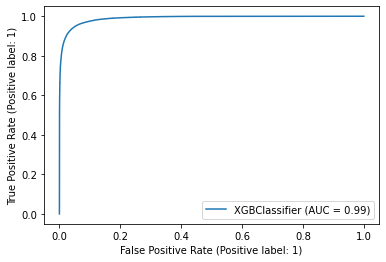

In [7]:
# performance without hpt
y_pred_xgb = model_xgb.predict(X_test)
result_xgb = accuracy_score(y_test, y_pred_xgb)
print('Accuracy is: ', round(result_xgb*100, 2))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

metrics.plot_roc_curve(model_xgb, X_test, y_test)  
plt.show()

In [8]:
# Manual HPT, n_estimators & max_depth are proportional to the accuracy, get accuracy 97.015%
n_estimators_list = [250, 500, 750, 1000]
max_depth_list = [4, 6, 8, 10]

for estim_list in n_estimators_list:
  for depth_list in max_depth_list:
    model = xgb.XGBClassifier(n_estimators=estim_list, max_depth=depth_list, random_state=42, tree_method='gpu_hist')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = confusion_matrix(y_test, y_pred)
    result2 = accuracy_score(y_test, y_pred)
    print(f'n_estimators: {estim_list}, max_depth: {depth_list}')
    print('Accuracy: ', result2)

n_estimators: 250, max_depth: 4
Accuracy:  0.9435055555555556
n_estimators: 250, max_depth: 6
Accuracy:  0.9630944444444445
n_estimators: 250, max_depth: 8
Accuracy:  0.9675833333333334
n_estimators: 250, max_depth: 10
Accuracy:  0.9675
n_estimators: 500, max_depth: 4
Accuracy:  0.9585833333333333
n_estimators: 500, max_depth: 6
Accuracy:  0.9679277777777778
n_estimators: 500, max_depth: 8
Accuracy:  0.9694166666666667
n_estimators: 500, max_depth: 10
Accuracy:  0.9688611111111111
n_estimators: 750, max_depth: 4
Accuracy:  0.9633777777777778
n_estimators: 750, max_depth: 6
Accuracy:  0.9687166666666667
n_estimators: 750, max_depth: 8
Accuracy:  0.9695888888888888
n_estimators: 750, max_depth: 10
Accuracy:  0.9698333333333333
n_estimators: 1000, max_depth: 4
Accuracy:  0.9647833333333333
n_estimators: 1000, max_depth: 6
Accuracy:  0.9685777777777778
n_estimators: 1000, max_depth: 8
Accuracy:  0.9699555555555556
n_estimators: 1000, max_depth: 10
Accuracy:  0.9701166666666666


In [ ]:
# Randomised HPT with more parameters
params = {"learning_rate" : [0.20, 0.30, 0.40],
          "max_depth" : [4, 6, 8, 10],
          "min_child_weight" : [1, 3, 5],
          "gamma": [0.0, 0.5, 1],
          "colsample_bytree" : [0.2, 0.5, 1],
          "n_estimators" : [500, 1000, 1500, 2000]}
rs_model = RandomizedSearchCV(model_xgb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
rs_model.fit(X,y)
rs_model.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(colsample_bytree=0.5, gamma=0.5, learning_rate=0.4, max_depth=10,
              n_estimators=1500, random_state=42, tree_method='gpu_hist')

Accuracy is:  96.83
[[89771  2684]
 [ 3029 84516]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92455
           1       0.97      0.97      0.97     87545

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


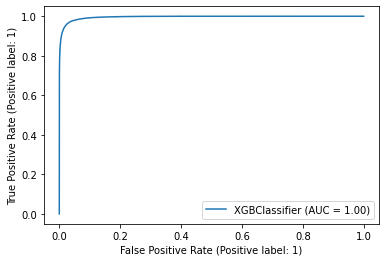

In [ ]:
# Check Randomised HPT result, worst than manual HPT
model_xgb_rs_hpt = xgb.XGBClassifier(colsample_bytree=0.5, gamma=0.5, learning_rate=0.4, max_depth=10, n_estimators=1500, random_state=42, tree_method='gpu_hist')
model_xgb_rs_hpt.fit(X_train, y_train)
y_pred_xgb_rs_hpt = model_xgb_rs_hpt.predict(X_test)
result_xgb = accuracy_score(y_test, y_pred_xgb_rs_hpt)
print('Accuracy is: ', round(result_xgb*100, 2))
print(confusion_matrix(y_test, y_pred_xgb_rs_hpt))
print(classification_report(y_test, y_pred_xgb_rs_hpt))

metrics.plot_roc_curve(model_xgb_rs_hpt, X_test, y_test)  
plt.show()

In [ ]:
# More manual HPT, get the highest accuracy 97.02%
n_estimators_list_2 = [1000, 1500, 2000]
max_depth_list_2 = [8, 10, 12, 14]

for estim_list in n_estimators_list_2:
  for depth_list in max_depth_list_2:
    model = xgb.XGBClassifier(n_estimators=estim_list, max_depth=depth_list, random_state=42, tree_method='gpu_hist')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = confusion_matrix(y_test, y_pred)
    result2 = accuracy_score(y_test, y_pred)
    print(f'n_estimators: {estim_list}, max_depth: {depth_list}')
    print('Accuracy: ', result2)

n_estimators: 1000, max_depth: 8
Accuracy:  0.9697888888888889
n_estimators: 1000, max_depth: 10
Accuracy:  0.9692277777777778
n_estimators: 1000, max_depth: 12
Accuracy:  0.9685944444444444
n_estimators: 1000, max_depth: 14
Accuracy:  0.9679055555555556
n_estimators: 1500, max_depth: 8
Accuracy:  0.9700388888888889
n_estimators: 1500, max_depth: 10
Accuracy:  0.9697166666666667
n_estimators: 1500, max_depth: 12
Accuracy:  0.9695166666666667
n_estimators: 1500, max_depth: 14
Accuracy:  0.9688222222222223
n_estimators: 2000, max_depth: 8
Accuracy:  0.9702666666666667
n_estimators: 2000, max_depth: 10
Accuracy:  0.9696388888888889
n_estimators: 2000, max_depth: 12
Accuracy:  0.9699833333333333
n_estimators: 2000, max_depth: 14
Accuracy:  0.9691722222222222


Accuracy is:  97.04
[[89947  2508]
 [ 2814 84731]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92455
           1       0.97      0.97      0.97     87545

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


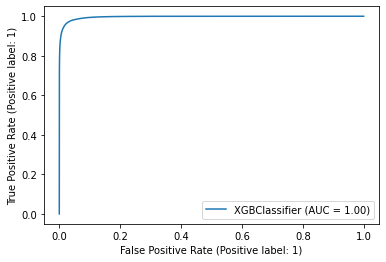

In [ ]:
# Performance with full fe, and hpt
model_xgb_final = xgb.XGBClassifier(n_estimators=2000, max_depth=8, random_state=42, tree_method='gpu_hist')
model_xgb_final.fit(X_train, y_train)
y_pred_xgb_final = model_xgb_final.predict(X_test)
result_xgb = accuracy_score(y_test, y_pred_xgb_final)
print('Accuracy is: ', round(result_xgb*100, 2))
print(confusion_matrix(y_test, y_pred_xgb_final))
print(classification_report(y_test, y_pred_xgb_final))

metrics.plot_roc_curve(model_xgb_final, X_test, y_test)  
plt.show()

### LGBM model

In [ ]:
#accuary and run time on this model was slower than xgboost so it wasnt implemented
model_lgb = lgb.LGBMClassifier(random_state=42, objective= 'binary',max_cat_to_onehot=10,n_estimators=750)
start = time.time()
model_lgb.fit(X_train, y_train)
end = time.time()
print(end-start)

In [ ]:
print(model_lgb.score(X_test,y_test))

In [ ]:
classification_report(y_predict, y_test)

### SMOTEENN
##### Since dataset was balanced, SMOTE did not contribute to accuracy

In [ ]:
# resulted in reduced accuracy
sm = SMOTEENN()
X_smote, y_smote = sm.fit_resample(X,y)

In [ ]:
# Using SMOTE-resampled data
X_train, X_test, y_train, y_test =  train_test_split(X_smote,y_smote,test_size=0.30,random_state=28)  

Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07', 'f_08',
       'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17',
       'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26',
       'f_28', 'f_29', 'f_30', 'f_27_set_len', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', 'sum_05_22', 'sum_02_21', 'sum_00_01_26'],
      dtype='object')

In [ ]:
model_xgb = xgb.XGBClassifier(tree_method='gpu_hist', random_state=28, max_cat_to_onehot=10, booster='gbtree', n_estimators=750, max_depth=10)

In [ ]:
start = time.time()
model_xgb.fit(X_train, y_train)
end = time.time()
y_predict = model_xgb.predict(X_test)
print(f'time taken:{end-start}\naccuracy:{round(accuracy_score(y_predict, y_test)*100,2)}')

time taken:133.66651320457458
accuracy:96.98


In [ ]:
result = classification_report(y_predict, y_test)
print(result)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    138695
           1       0.97      0.97      0.97    131305

    accuracy                           0.97    270000
   macro avg       0.97      0.97      0.97    270000
weighted avg       0.97      0.97      0.97    270000



### K-folds
##### Likewise, did not add value to scores

In [ ]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
folds = StratifiedKFold(n_splits=10)

scores_xgb = []

for train_index, test_index in folds.split(X,y):
    X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.20,random_state=101)
    scores_xgb.append(get_score(xgb.XGBClassifier(random_state=28,tree_method='gpu_hist', n_estimators=5000, max_depth=15, booster='gbtree', learning_rate=0.4), X_train, X_test, y_train, y_test))

In [ ]:
scores_xgb

[0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963,
 0.9695962962962963]

### Kaggle submission: prediction and export to .csv 

In [ ]:
# Rerun model with entire training data to improve prediction for Kaggle
# model_xgb.fit(X,y)

In [ ]:
pred = model_xgb.predict(test)

In [ ]:
df_test = pd.read_csv('./df_test.csv')

test_id = df_test.id.values
submission_df = pd.DataFrame({
    "id" : test_id,
    "target": pred
})

submission_df.set_index('id', inplace=True)
submission_df.value_counts()

target
0         360820
1         339180
dtype: int64

In [ ]:
submission_df.to_csv('submission_05-30.csv')

In [ ]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

f_27_set_len    0.054406
2               0.037095
sum_00_01_26    0.028178
f_30            0.026884
0               0.023924
9               0.022775
8               0.018602
sum_02_21       0.018495
5               0.017994
1               0.016842
4               0.016428
3               0.015800
6               0.015239
f_15            0.015105
f_11            0.014056
f_13            0.013471
f_14            0.013362
f_16            0.012875
f_10            0.012777
f_08            0.012742
sum_05_22       0.012684
f_09            0.012578
f_21            0.012405
f_17            0.012022
f_12            0.011907
f_18            0.011108
f_07            0.010408
7               0.010269
f_29            0.009852
f_26            0.008408
f_28            0.005725
f_23            0.005525
f_19            0.004731
f_22            0.004496
f_24            0.003896
f_25            0.002733
f_00            0.002680
f_05            0.001429
f_01            0.001210
f_20            0.001198


In [ ]:
#xgb.set_config(use_rmm=True)